In [1]:
import pandas as pd 
import numpy as np
import tensorly as tl
import plotly.express as px
import matplotlib.pyplot as plt 
from tensorly.decomposition import CP,tucker, parafac, non_negative_tucker
from datetime import timedelta, date

In [36]:
# df_FR = pd.read_excel('FINANCIAL_RATIOS_f.xlsx', index_col =[0])
# price = None
FR_dic = {}
FR_list = ['PE', 'PX_LAST', 'PS','PB']
n = 0 
NUMBER_OF_STOCKS = 220
for i,name in enumerate(FR_list) : 
    FR_dic[name] = (df_FR.iloc[:,n:n+NUMBER_OF_STOCKS]
                    .set_index(df_FR.index)
                    )

    # if name not in ['PX_LAST', 'MCAP'] : 
        # FR_dic[name] = (FR_dic[name] - FR_dic[name].mean()) / FR_dic[name].std()
        
    if name in ['PX_LAST'] :

        price = FR_dic['PX_LAST']
        FR_dic[name] = np.log(FR_dic[name])
        FR_dic[name] = FR_dic[name].diff()
    

    
    FR_dic[name] = FR_dic[name][1:]
    n += NUMBER_OF_STOCKS + 2

COLUMN_NAMES = FR_dic['PE'].columns
FR_index = FR_dic['PE'].index



In [ ]:
df_TI = pd.read_excel('TECH_NEW.xlsx', skiprows=[0])

TI_dic = {}
TI_list = ['BB_PERCENT', 'HURST', 'MOM', 'ROC','RSI','WLPR']
n = 1

for _, TI in enumerate(TI_list) : 
    filter_col = [col for col in df_TI if col.startswith(TI)]
    TI_dic[TI] = (df_TI[filter_col]
                 .set_axis(COLUMN_NAMES, axis=1)
                 .set_index(df_TI['Dates'])
                 .iloc[:-1]
                 .fillna(method = 'ffill')
                 .set_index(FR_index)
                 )
    # TI_dic[TI] = (TI_dic[TI] - TI_dic[TI].mean()) / TI_dic[TI].std()
TI_dic.pop('ROC', None)
TI_dic.pop('WLPR', None)
TI_dic.pop('BB_PERCENT', None)

In [37]:
solo_df = pd.DataFrame()

test_company = 'AMAT'
k = 0
for key,value in FR_dic.items() : 
    if k == 0 : 
        solo_df[key] = value[f'{test_company} US Equity']
    if k > 0 : 
        solo_df[key] = value[f'{test_company} US Equity'+ f'.{k}']
    k+=1

for key,value in TI_dic.items() : 
    solo_df[key] = value[f'{test_company} US Equity']

look_back_duration = 2
look_forward = 2

In [ ]:
look_back_duration = 2
look_forward = 2

In [44]:
for col in FR_dic['PX_LAST'] : 
    if col.startswith(test_company) : 
        y_predict = FR_dic['PX_LAST'][col]

test_comp_returns = pd.DataFrame(y_predict).set_axis(['Log Returns'], axis = 1)
test_comp_returns['Cumulative Log Returns'] = test_comp_returns['Log Returns'].cumsum()
def get_n_week_retuns(log_returns, look_back_duration, lookforward) : 
    sdate = test_comp_returns.index.values[0]
    edate = test_comp_returns.index.values[-1]
    s = (log_returns
     .reset_index()
     .iloc[look_back_duration:]
    )
    n_week_retuns = s.rolling(lookforward).sum()
    n_week_retuns.index = list(pd.date_range(sdate ,edate + pd.to_timedelta(2, unit='D') ,freq='w') - pd.to_timedelta(2, unit='D'))[:-look_back_duration]
    return n_week_retuns.dropna() 


def to_simple_return(cum_log_ret) : 
    return np.exp(cum_log_ret) - 1

y_ret_list = [] 
look_back_list =  [look_back_duration] #how many periods we look back
look_f_list = [2,3] # how many periods we look forward
for i in range(len(look_back_list)) :
    # for j in range(len(look_f_list)) :
    for j in range(1) :  
        tmp = get_n_week_retuns(test_comp_returns['Log Returns'], look_back_duration = look_back_list[i], lookforward = look_f_list[j])
        print(tmp.shape)
        y_ret_list.append(tmp)


(808, 1)


In [46]:
get_n_week_retuns(test_comp_returns['Log Returns'], look_back_duration, look_forward)

,Log Returns
2006-11-24,-0.002703
2006-12-01,0.022310
2006-12-08,-0.016926
2006-12-15,0.017496
2006-12-22,0.027697
...,...
2022-04-15,-0.026911
2022-04-22,-0.002663
2022-04-29,0.013591
2022-05-06,-0.055184


In [41]:
import sys
import numpy as np 
np.set_printoptions(threshold=sys.maxsize)

# FR_dic.pop('PX_LAST',None)
ft1 =  np.stack(FR_dic.values(), axis=2)
ft2 = np.stack(TI_dic.values(), axis=2)

feature_tensor = np.dstack((ft1, ft2))


# There is 813 datasets to train on
# We first apply the tucker decomposition and then vectorize the values.

    
print(feature_tensor.shape)
core, factors = tucker(feature_tensor, rank= [811,100,6]) # 711 time, 20 stocks, 9 
pc = tl.tenalg.mode_dot(feature_tensor, factors[1].T, mode = 1)


rec = tl.tucker_to_tensor((core,factors))
rec_error = tl.norm(rec - feature_tensor)/tl.norm(feature_tensor)
print(rec_error)



list_of_features = [] #Split the features into different look_back_duration time slots. 
for i in range(0,len(feature_tensor)-look_back_duration-look_forward+1) : 
    list_of_features.append(feature_tensor[i:i+look_back_duration, :,:])



list_of_solo_f = []
#SOLO FEATURES FOR AAPL
for i in range(0,len(solo_df)-look_back_duration-look_forward+1) : 
    list_of_solo_f.append(solo_df[i:i+look_back_duration].to_numpy())

(811, 220, 10)
0.11896161195495776


Text(0, 0.5, 'Reconstruction error')

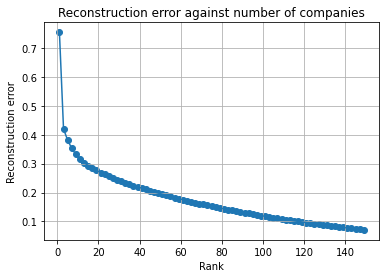

In [42]:
# import sys
# import numpy as np 
# np.set_printoptions(threshold=sys.maxsize)

ft1 =  np.stack(FR_dic.values(), axis=2)
ft2 = np.stack(TI_dic.values(), axis=2)
feature_tensor = np.dstack((ft1, ft2))

error_list = []
for n in np.arange(1,150,2) : 
    core, factors = tucker(feature_tensor, rank= [711,n,6])
    pc = tl.tenalg.mode_dot(feature_tensor, factors[1].T, mode = 1)
    rec = tl.tucker_to_tensor((core,factors))
    rec_error = tl.norm(rec - feature_tensor)/tl.norm(feature_tensor)
    error_list.append(rec_error)
fig, ax = plt.subplots(1)
ax.plot(np.arange(1,150,2), error_list)
ax.scatter(np.arange(1,150,2), error_list)
ax.grid('On')
ax.set_title("Reconstruction error against number of companies")
ax.set_xlabel("Rank")
ax.set_ylabel("Reconstruction error")

In [ ]:
# x_ret_list contains the 
y_train_list = [] 

for y_train in y_ret_list : 
    y_arr = y_train.values
    y_arr = y_arr.flatten()
    y_arr[(y_arr > 0)] = 1

    y_arr[y_arr <= 0] = -1

    y_train_list.append(y_arr)


list_of_combined_features = []
for feature_t,solo_feature in zip(list_of_features,list_of_solo_f)  :
    solo_feature = solo_feature[:,newaxis,:]
    tmp = np.concatenate((feature_t,solo_feature), axis=1)
    list_of_combined_features.append(tmp)

# ans = [np.stack([feature_t,solo_feature],axis=2)   for feature_t,solo_feature in zip(list_of_decomposed_features,list_of_solo_f)]
# print(ans[0].shape)
X_Cols = [tensor.flatten() for tensor in list_of_features ]

S_Cols = [mat.flatten() for mat in list_of_solo_f]

C_Cols = [tensor.flatten() for tensor in list_of_combined_features]

X_Cols, S_Cols, C_Cols = X_Cols[:-120], S_Cols[:-120] , C_Cols[:-120]


y_train_list[0] = y_train_list[0][:-120]

X_val, S_val, C_val, Y_val = X_Cols[-120:], S_Cols[-120:], C_Cols[-120:], y_train_list[0][-120:]
